In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix,roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

# Functions

In [2]:
def train_test_split_per_user(data, train_size=0.7):
    users = list(set(data.id))
    users = sorted(users, reverse=True)  # fix randomness
    total_users = len(users)
    slice_idx = int(train_size * total_users)
    users_train = users[:slice_idx]
    users_test = users[slice_idx:]
    
    # Split data based on user IDs
    train_data = data[data.id.isin(users_train)]
    test_data = data[data.id.isin(users_test)]
    
    x_train = train_data.drop(['id', 'label_stress_sema'], axis=1) 
    y_train = train_data['label_stress_sema']  
    x_test = test_data.drop(['id', 'label_stress_sema'], axis=1) 
    y_test = test_data['label_stress_sema']  
    
    return x_train, y_train, x_test, y_test

In [3]:
def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

In [4]:
def plot_roc_curve(y_true, y_scores):
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [5]:
custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
complementary_colors = ['#a9d0f5', '#f3ba8c', '#98e698', '#f5a9a9', '#d8b5d8', '#d2a6a6', '#f5a9f2', '#d8d8d8']

full_palette = custom_colors + complementary_colors
sns.set_palette(full_palette)

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 15

In [6]:
df = pd.read_pickle('../data/lifesnaps/lifesnapsv1.pkl')
df['id'] = df['id'].astype(str)
df = df[df['label_stress_sema'].notna()]
df

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,...,minutes_in_default_zone_1,minutes_below_default_zone_1,minutes_in_default_zone_2,minutes_in_default_zone_3,age,gender,bmi,label_stress_sema,negative_affect_category,stai_stress_category
1,621e30e467b776a240e817c7,2021-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,105.0,703.0,64.0,2.0,<30,MALE,>=30,1.0,Average,Average
6,621e32af67b776a24045b4cf,2021-05-24,NaN,51.622,43.536,97.8,13.8,79.0,0.833333,0.700,...,77.0,1289.0,0.0,0.0,<30,MALE,22.0,0.0,Average,Average
8,621e301e67b776a240608a72,2021-05-24,34.710232,NaN,NaN,NaN,NaN,74.0,0.700000,0.700,...,164.0,997.0,49.0,0.0,<30,FEMALE,19.0,0.0,Average,Average
9,621e337667b776a240ce78ab,2021-05-24,33.662874,52.927,39.939,95.5,11.2,60.0,0.633333,0.550,...,6.0,1434.0,0.0,0.0,<30,MALE,21.0,0.0,Average,Average
17,621e2f7a67b776a240f14425,2021-05-24,32.556993,NaN,NaN,96.7,NaN,NaN,NaN,NaN,...,0.0,1440.0,0.0,0.0,>=30,MALE,24.0,0.0,Average,Average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4873,621e33cf67b776a240087de9,2022-01-16,33.892631,62.859,49.395,NaN,12.0,77.0,0.566667,0.925,...,283.0,1157.0,0.0,0.0,>=30,MALE,26.0,1.0,Average,Average
4888,621e346f67b776a24081744f,2022-01-17,32.903545,71.863,25.475,NaN,18.2,72.0,0.833333,0.625,...,56.0,1384.0,0.0,0.0,NaN,NaN,NaN,1.0,Average,Average
4891,621e2f9167b776a240011ccb,2022-01-17,34.716690,58.489,28.329,96.5,14.2,76.0,0.800000,0.600,...,195.0,1104.0,4.0,0.0,>=30,FEMALE,20.0,1.0,Average,Average
4900,621e331067b776a24085dd3f,2022-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,>=30,FEMALE,21.0,0.0,Average,Average


In [7]:
df.columns

Index(['id', 'date', 'nightly_temperature', 'nremhr', 'rmssd', 'spo2',
       'full_sleep_breathing_rate', 'stress_score', 'sleep_points_percentage',
       'exertion_points_percentage', 'responsiveness_points_percentage',
       'daily_temperature_variation', 'badgeType', 'calories',
       'filteredDemographicVO2Max', 'distance', 'activityType', 'bpm',
       'lightly_active_minutes', 'moderately_active_minutes',
       'very_active_minutes', 'sedentary_minutes', 'mindfulness_session',
       'scl_avg', 'resting_hr', 'sleep_duration', 'minutesToFallAsleep',
       'minutesAsleep', 'minutesAwake', 'minutesAfterWakeup',
       'sleep_efficiency', 'sleep_deep_ratio', 'sleep_wake_ratio',
       'sleep_light_ratio', 'sleep_rem_ratio', 'steps',
       'minutes_in_default_zone_1', 'minutes_below_default_zone_1',
       'minutes_in_default_zone_2', 'minutes_in_default_zone_3', 'age',
       'gender', 'bmi', 'label_stress_sema', 'negative_affect_category',
       'stai_stress_category'],
    

In [8]:
df = df.drop(columns=['date', 'negative_affect_category',
       'stai_stress_category' ])
df

,id,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,responsiveness_points_percentage,...,sleep_rem_ratio,steps,minutes_in_default_zone_1,minutes_below_default_zone_1,minutes_in_default_zone_2,minutes_in_default_zone_3,age,gender,bmi,label_stress_sema
1,621e30e467b776a240e817c7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6506.0,105.0,703.0,64.0,2.0,<30,MALE,>=30,1.0
6,621e32af67b776a24045b4cf,NaN,51.622,43.536,97.8,13.8,79.0,0.833333,0.700,0.866667,...,NaN,7796.0,77.0,1289.0,0.0,0.0,<30,MALE,22.0,0.0
8,621e301e67b776a240608a72,34.710232,NaN,NaN,NaN,NaN,74.0,0.700000,0.700,0.833333,...,0.922222,12441.0,164.0,997.0,49.0,0.0,<30,FEMALE,19.0,0.0
9,621e337667b776a240ce78ab,33.662874,52.927,39.939,95.5,11.2,60.0,0.633333,0.550,0.633333,...,0.663462,6858.0,6.0,1434.0,0.0,0.0,<30,MALE,21.0,0.0
17,621e2f7a67b776a240f14425,32.556993,NaN,NaN,96.7,NaN,NaN,NaN,NaN,NaN,...,1.375000,1776.0,0.0,1440.0,0.0,0.0,>=30,MALE,24.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4873,621e33cf67b776a240087de9,33.892631,62.859,49.395,NaN,12.0,77.0,0.566667,0.925,0.766667,...,0.263889,10823.0,283.0,1157.0,0.0,0.0,>=30,MALE,26.0,1.0
4888,621e346f67b776a24081744f,32.903545,71.863,25.475,NaN,18.2,72.0,0.833333,0.625,0.733333,...,1.016529,2528.0,56.0,1384.0,0.0,0.0,NaN,NaN,NaN,1.0
4891,621e2f9167b776a240011ccb,34.716690,58.489,28.329,96.5,14.2,76.0,0.800000,0.600,0.933333,...,0.634615,7876.0,195.0,1104.0,4.0,0.0,>=30,FEMALE,20.0,1.0
4900,621e331067b776a24085dd3f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,>=30,FEMALE,21.0,0.0


In [9]:
X_train, y_train, X_test, y_test = train_test_split_per_user(df)

In [10]:
# Handling missing values
df.fillna(df.median(), inplace=True)  

# Convert categorical variables
categorical_features = ['gender', 'age', 'bmi'] 
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
    ])

# Define the model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier())])

C:\Users\ChristinaKaragianni\AppData\Local\Temp\ipykernel_12816\3607260268.py:2: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.fillna(df.median(), inplace=True)


In [11]:
# Train the model
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.77      1.00      0.87       593
         1.0       0.00      0.00      0.00       173

    accuracy                           0.77       766
   macro avg       0.39      0.50      0.44       766
weighted avg       0.60      0.77      0.68       766


C:\Users\ChristinaKaragianni\anaconda3\envs\py38\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ChristinaKaragianni\anaconda3\envs\py38\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ChristinaKaragianni\anaconda3\envs\py38\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

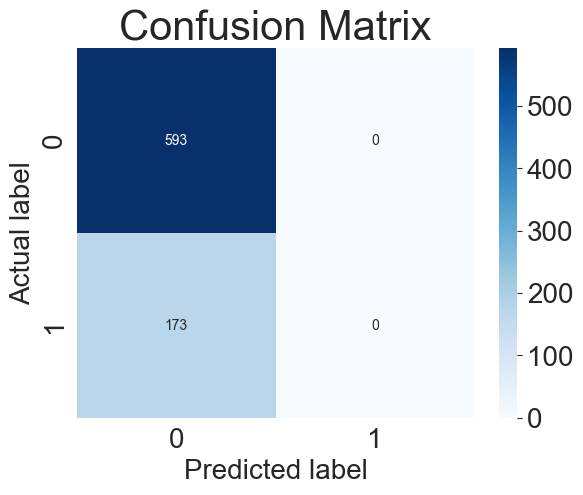

In [12]:
plot_confusion_matrix(y_test, y_pred)

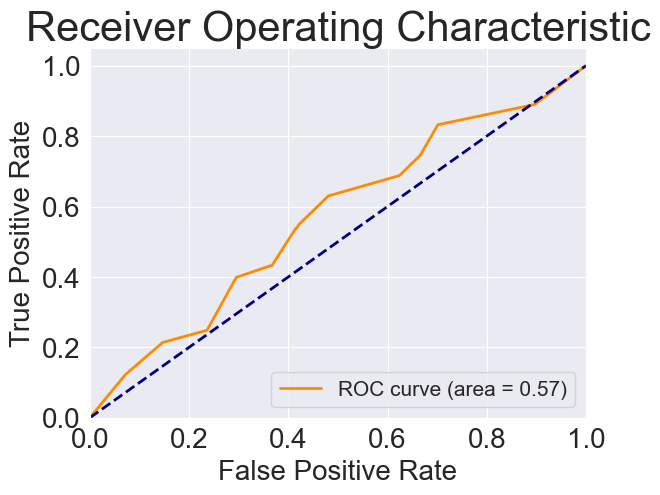

In [13]:
y_scores = model.predict_proba(X_test)[:, 1]  # Assuming the positive class is at index 1

plot_roc_curve(y_test, y_scores)